# Visual Search Using Variational Autoeconders

In this notebook, we develop a prototype for unsupervised embedding learning using the variational autoencoder (VAE). We train the VAE on the Fashion MNIST dataset, and demonstrate it is capable of learning a smooth regular manifold. The embeddings obtained using VAE can be used for nearest neighbor search. 

This notebook is based on Tim Sainburg's implementation of VAE [1]. 

### Data 
We use the `Fashion MNIST` dataset. See `datasets.ms` for details.

### References
[1] https://github.com/timsainb/tensorflow2-generative-models

In [5]:
import os
import numpy as np
import pandas as pd
import random
import warnings
from tabulate import tabulate

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import tensorflow_probability as tfp
ds = tfp.distributions

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'pdf.fonttype': 'truetype'})
warnings.simplefilter("ignore")


# Load Data: Fashion MNIST

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

TRAIN_BUF = 60000
BATCH_SIZE = 512
DIMS = (28, 28, 1)
N_TRAIN_BATCHES = int(TRAIN_BUF/BATCH_SIZE)

# split dataset
train_images = x_train.reshape(x_train.shape[0], 28, 28, 1).astype("float32") / 255.0
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)

4422102/4422102 [==============================] - 1s 0us/step


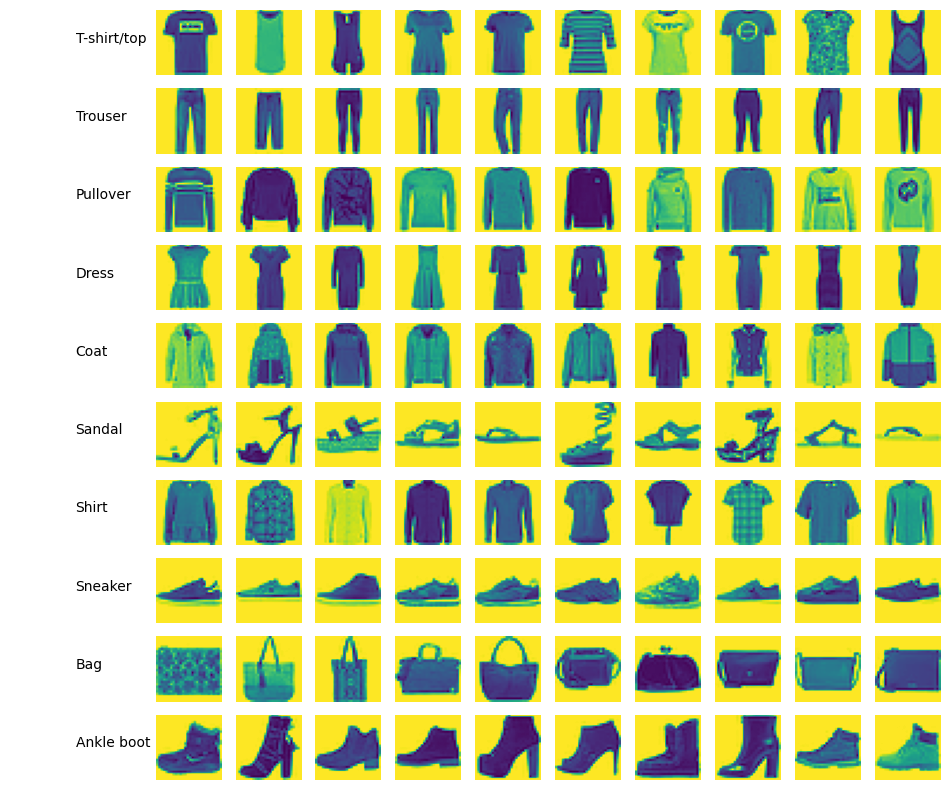

In [7]:
# Define the text labels
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9

fig, ax = plt.subplots(10, 11, figsize=(12, 10), gridspec_kw={'width_ratios': [2] + [1]*10})
img_idx = 0
for i in range(10):
    ax[i, 0].axis('off')
    ax[i, 0].text(0.5, 0.5, fashion_mnist_labels[i])
    
    class_indexes = [k for k, n in enumerate(y_train) if n == i]
    for j in range(10):
        ax[i, j+1].imshow(1 - train_images[class_indexes[j], :])
        ax[i, j+1].axis('off')

# Variational Autoencoder Model

In [28]:
class VAE(tf.keras.Model):
    def __init__(self, input_shape, **kwargs):
        super(VAE, self).__init__()
        self.input_shape = input_shape
        self.__dict__.update(kwargs)

        self.enc = tf.keras.Sequential(self.enc)
        self.dec = tf.keras.Sequential(self.dec)

    def encode(self, x):
        mu, sigma = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def reconstruct(self, x):
        mu, _ = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return self.decode(mu)

    def decode(self, z):
        return self.dec(z)

    def compute_loss(self, x):
        q_z = self.encode(x)
        z = q_z.sample()
        x_recon = self.decode(z)
        p_z = ds.MultivariateNormalDiag(
            loc=[0.] * z.shape[-1], scale_diag=[1.] * z.shape[-1]
        )
        kl_div = ds.kl_divergence(q_z, p_z)
        latent_loss = tf.reduce_mean(tf.maximum(kl_div, 0))
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.math.square(x - x_recon), axis=0))

        return recon_loss, latent_loss

    def compute_gradients(self, x):
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x)
        return tape.gradient(loss, self.trainable_variables)

    @tf.function
    def train(self, train_x):
        gradients = self.compute_gradients(train_x)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    def call(self, x):
        mu, sigma = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

            
            
        
N_Z = 2
input_shape = (28, 28, 1)  # Adjust this based on your input data shape
encoder = [
    tf.keras.layers.InputLayer(input_shape=input_shape),
    #tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=N_Z*2),
]

decoder = [
    tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
]

#
# Model training
#
# Define the input shape
input_shape = (28, 28, 1)  # Adjust this based on your input data shape

# Model training
optimizer = tf.keras.optimizers.Adam(1e-3)
model = VAE(
    input_shape=input_shape,  # Provide the input_shape argument
    enc=encoder,
    dec=decoder,
    optimizer=optimizer,
)

n_epochs = 5
for epoch in range(n_epochs):
    print(f'Epoch {epoch}...')
    for batch, train_x in zip(range(N_TRAIN_BATCHES), train_dataset):
        model.train(train_x)

TypeError: VAE.__init__() missing 1 required positional argument: 'input_shape'

In [27]:
model.save("vae_model", save_format="tf")


ValueError: Model <__main__.VAE object at 0x2dda530a0> cannot be saved either because the input shape is not available or because the forward pass of the model is not defined.To define a forward pass, please override `Model.call()`. To specify an input shape, either call `build(input_shape)` directly, or call the model on actual data using `Model()`, `Model.fit()`, or `Model.predict()`. If you have a custom training step, please make sure to invoke the forward pass in train step through `Model.__call__`, i.e. `model(inputs)`, as opposed to `model.call()`.

# Manifold Visualization

(-0.5, 279.5, 279.5, -0.5)

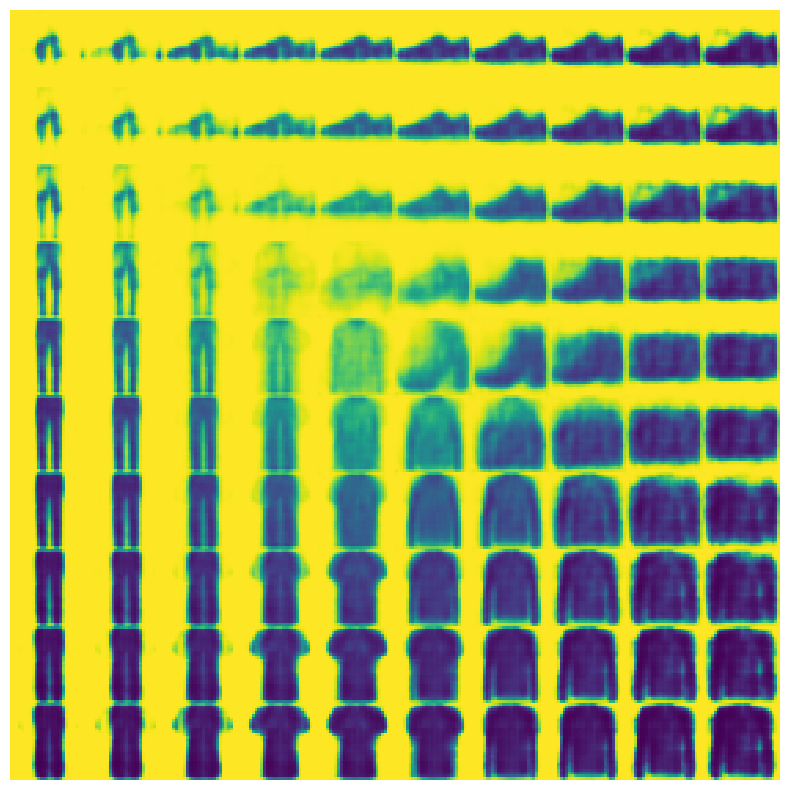

In [13]:
#
# Create a grid over the semantic space
#
nx = ny = 10
meshgrid = np.meshgrid(np.linspace(-3, 3, nx), np.linspace(-3, 3, ny))
meshgrid = np.array(meshgrid).reshape(2, nx*ny).T

#
# Decode the points of the semantic space into images 
#
x_grid = model.decode(meshgrid)
x_grid = x_grid.numpy().reshape(nx, ny, 28,28, 1)

#
# Visualize the reconstructed images
#
canvas = np.zeros((nx*28, ny*28))
for xi in range(nx):
    for yi in range(ny):
        canvas[xi*28 : xi*28+28,  yi*28 : yi*28+28] = x_grid[xi, yi, :, :, :].squeeze()
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(1 - canvas)
ax.axis('off')

# Query Nearest Neighbors

In [14]:
embeddigns, _ = tf.split(model.enc(train_images), num_or_size_splits=2, axis=1)

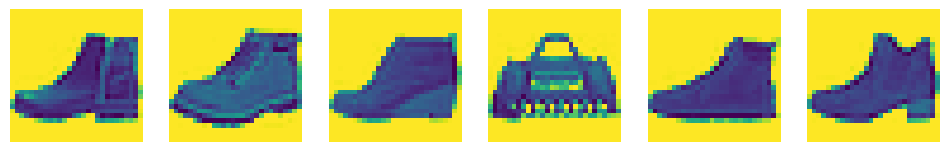

In [15]:
query_image_id = 15
k = 6


def query(image_id, k):
    query_embedding = embeddigns[image_id]
    distances = np.zeros(len(embeddigns))
    for i, e in enumerate(embeddigns):
        distances[i] = np.linalg.norm(query_embedding - e)
    return np.argpartition(distances, k)[:k]

idx = query(query_image_id, k=k)

fig, ax = plt.subplots(1, k, figsize=(k*2, 2))
for i in range(k):
    ax[i].imshow(1 - train_images[idx[i], :])
    ax[i].axis('off')
    
plt.savefig('query-example-2.pdf')